<a href="https://colab.research.google.com/github/JanjaTomic/OSiRV/blob/main/obradaslike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
from google.colab import files
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [3]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [4]:
! kaggle datasets download -d landlord/handwriting-recognition

100% 1.26G/1.26G [00:34<00:00, 42.6MB/s]
100% 1.26G/1.26G [00:34<00:00, 39.1MB/s]


In [5]:
with zipfile.ZipFile('/content/handwriting-recognition.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [7]:
def load_image_paths_from_directory(directory, max_images=100000):
    image_filepaths = []
    count = 0
    filenames = os.listdir(directory)
    filenames.sort()

    for filename in filenames:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            image_filepaths.append(filepath)
            count += 1
            if count >= max_images:
                break

    return image_filepaths

In [8]:
def load_image(image_path):
    image = cv2.imread(image_path)

    if image is not None:
        if image.shape[0] > 25:
            cropped_image = image[5:, :, :]
        else:
            cropped_image = image

    return cropped_image

In [9]:
def segment_letters(image_path):

    image = load_image(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    letter_images = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if 130 > cv2.contourArea(contour) > 30 and h > 5 and w > 3 and w < 30:
            letter = gray[y:y+h, x:x+w]
            letter = cv2.resize(letter, (32, 32))
            letter_images.append(letter)

    return letter_images

In [36]:
def segment_letters_in_array(image_array, word_list):
    segmented_letters_array = []
    connected_words = []

    for image, word in zip(image_array, word_list):
        word_validity = True
        letter_images = segment_letters(image)
        if word and word != "UNREADABLE" and isinstance(word, str):
          word = word.replace(" ","")
          word = word.upper()
          for letter in word:
            if letter == "-" or letter == "%" or letter == "&" or letter == "'":
              word_validity = False
          if len(word) == len(letter_images) and word_validity:
            segmented_letters_array.extend(letter_images)
            connected_words.extend(word)

    return segmented_letters_array, connected_words

In [11]:
def display_acc_graph(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Accuracy Graph")
    plt.legend()
    plt.figure()

def display_loss_graph(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Loss Graph")
    plt.legend()
    plt.show()

In [12]:
def display_segmented_letters(segmented_letters):
    num_images = len(segmented_letters)
    num_cols = 8
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    if num_rows == 1:
        axes = axes.reshape(1, -1)
    if num_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, letter in enumerate(segmented_letters):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(letter, cmap='gray')
        ax.axis('off')

    for j in range(i + 1, num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

    plt.show()

In [6]:
train_dir = "/content/train_v2/train/"
test_dir = "/content/test_v2/test/"
validation_dir = "/content/validation_v2/validation/"

In [13]:
df_train = pd.read_csv('/content/written_name_train_v2.csv')

In [14]:
df_val = pd.read_csv('/content/written_name_validation_v2.csv')

In [15]:
trainNum = 50000
valNum = 10000

In [16]:
word_list_train = df_train['IDENTITY'][:trainNum]
image_paths_train = load_image_paths_from_directory(train_dir, trainNum)

In [17]:
word_list_val = df_val['IDENTITY'][:valNum]
image_paths_val = load_image_paths_from_directory(validation_dir, valNum)

In [37]:
segmented_letters_train, connected_words_train = segment_letters_in_array(image_paths_train, word_list_train)

In [38]:
segmented_letters_val, connected_words_val = segment_letters_in_array(image_paths_val, word_list_val)

In [20]:
print(len(connected_words_train))
print(len(segmented_letters_train))

67809
67809


In [39]:
word_string = ''.join(connected_words_train)
unique_characters = set(word_string)
unique_characters = sorted(unique_characters)
print("Number of unique characters:", len(unique_characters))
print(unique_characters)

Number of unique characters: 26
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [40]:
word_string = ''.join(connected_words_val)
unique_characters_val = set(word_string)
unique_characters_val = sorted(unique_characters_val)
print("Number of unique characters:", len(unique_characters_val))
print(unique_characters_val)

Number of unique characters: 26
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [41]:
letter_image_dict_train = {}

for letter, image in zip(connected_words_train, segmented_letters_train):
    letter_image_dict_train.setdefault(letter, []).append(image)

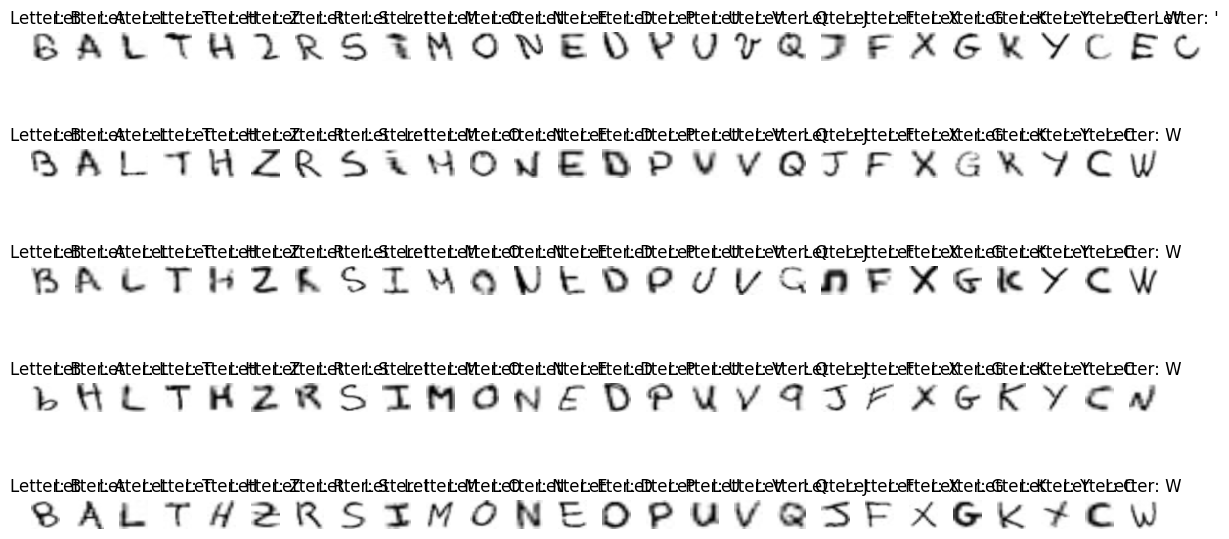

In [24]:
plt.figure(figsize=(12, 6))

for idx, (letter, images) in enumerate(letter_image_dict_train.items()):
    for i, image in enumerate(images[:5]):
        plt.subplot(5, len(letter_image_dict_train), i * len(letter_image_dict_train) + idx + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Letter: {letter}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [42]:
X_train = np.array(segmented_letters_train)
X_train = np.expand_dims(X_train, axis=-1)
X_train = np.repeat(X_train, 3, axis=-1)
X_train = preprocess_input(X_train)

In [43]:
X_val = np.array(segmented_letters_val)
X_val = np.expand_dims(X_val, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)
X_val = preprocess_input(X_val)

In [44]:
numerical_values = [unique_characters.index(letter) for letter in connected_words_train]
y_train = to_categorical(numerical_values, num_classes=len(unique_characters))

In [45]:
numerical_values = [unique_characters_val.index(letter) for letter in connected_words_val]
y_val = to_categorical(numerical_values, num_classes=len(unique_characters_val))

In [46]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [47]:
for layer in vgg_model.layers:
    layer.trainable = False

In [48]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_characters), activation='softmax'))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr = ReduceLROnPlateau(factor=0.5, patience=5)

In [49]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, callbacks=[early_stopping,lr], validation_data=(X_val, y_val)))

Epoch 1/10
2119/2119 [==============================] - 7187s 3s/step - loss: 2.8713 - accuracy: 0.3619 - val_loss: 2.8384 - val_accuracy: 0.2861
Epoch 2/10
2119/2119 [==============================] - 7187s 3s/step - loss: 2.3008 - accuracy: 0.4382 - val_loss: 2.7462 - val_accuracy: 0.2976
Epoch 3/10
  67/2119 [..............................] - ETA: 2:16:01 - loss: 2.2534 - accuracy: 0.4478

In [ ]:
display_acc_graph(history)
display_loss_graph(history)

In [ ]:
df_test = pd.read_csv('/content/written_name_test_v2.csv')

testNum = 10000
word_list_test = df_train['IDENTITY'][:testNum]
image_paths_test = load_image_paths_from_directory(test_dir, testNum)

segmented_letters_test, connected_words_test = segment_letters_in_array(image_paths_test, word_list_test)

word_string = ''.join(connected_words_test)
unique_characters_test = set(word_string)
unique_characters_test = sorted(unique_characters_test)
print("Number of unique characters:", len(unique_characters_test))
print(unique_characters_test)

X_test = np.array(segmented_letters_test)
X_test = np.expand_dims(X_test, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)
X_test = preprocess_input(X_test)

numerical_values = [unique_characters_test.index(letter) for letter in connected_words_test]
y_test = to_categorical(numerical_values, num_classes=len(unique_characters_test))

In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_characters_test, yticklabels=unique_characters_test)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()